In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px  # to plot the time series plot
from sklearn import metrics  # for the evaluation
from sklearn.preprocessing import MinMaxScaler, MultiLabelBinarizer
import tensorflow as tf
from foursquareAPI import get_poi

In [2]:
df = pd.read_csv("Parkirisca_do_10_05_2022.csv")
df["Zasedenost"] = df["Kapaciteta"] - df["Prosta mesta"]
df['date'] = pd.to_datetime(df["Datum"], unit="s")
df = df.drop(["Datum", "Prosta (narocniki)", "Oddana (narocniki)",
             "Na voljo (narocniki)", "Cakalna vrsta (narocniki)"], axis=1)
print(df)

                         Parkirisce  Prosta mesta  Kapaciteta  Zasedenost  \
0                          Bezigrad            58          64           6   
1                    Center Stozice           142         509         367   
2       Dolenjska cesta (Strelisce)            50          67          17   
3                   Gosarjeva ulica            16         190         174   
4               Gosarjeva ulica II.           121         115          -6   
...                             ...           ...         ...         ...   
292887                  SRC Stozice             0           0           0   
292888                        Tacen             0           0           0   
292889                 Bratislavska             0           0           0   
292890                       BS4/ I            63          80          17   
292891                      BS4/ II             8          83          75   

                      date  
0      2022-02-24 19:13:21  
1      2022-02-24

In [3]:
def copy_and_impute(parking):
    # Prepare new data frame, which will be synced (freqeuncy is exactly 10 mins)
    parking_sync = parking.asfreq("10 min")

    # Copy data before hole 1
    hole_start_date1 = pd.to_datetime("2022-03-15 08:25:12", format='%Y-%m-%d %H:%M:%S')
    for ((index, row), (index_sync, row_sync)) in zip(parking.iterrows(), parking_sync.iterrows()):
        if index > hole_start_date1:
            break
        row_sync["Zasedenost"] = row["Zasedenost"]

    # Impute first hole
    hole_end_date1 = pd.to_datetime("2022-03-23 07:02:59", format='%Y-%m-%d %H:%M:%S')
    num_rows_imputed = 0
    for index_sync, row_sync in parking_sync.iterrows():
        if index_sync <= hole_start_date1:
            continue
        if index_sync >= hole_end_date1:
            break
        # Repeat data from previous week day
        row_sync["Zasedenost"] = parking_sync[parking_sync.index ==
                                              index_sync - pd.to_timedelta(1, unit="W")]["Zasedenost"][0]
        num_rows_imputed += 1

    # Copy data after hole 1, before hole 2
    hole_start_date2 = pd.to_datetime("2022-04-07 22:10:55", format='%Y-%m-%d %H:%M:%S')
    for ((index, row), (index_sync, row_sync)) in zip(parking.iterrows(), parking_sync.iloc[num_rows_imputed:].iterrows()):
        if index < hole_end_date1:
            continue
        if index >= hole_start_date2:
            break
        row_sync["Zasedenost"] = row["Zasedenost"]

    # Impute second hole
    hole_end_date2 = pd.to_datetime("2022-04-22 08:11:54", format='%Y-%m-%d %H:%M:%S')
    for index_sync, row_sync in parking_sync.iterrows():
        if index_sync <= hole_start_date2:
            continue
        if index_sync > hole_end_date2:
            break
        # Repeat data from previous week day
        row_sync["Zasedenost"] = parking_sync[parking_sync.index ==
                                              index_sync - pd.to_timedelta(1, unit="W")]["Zasedenost"][0]
        num_rows_imputed += 1

    # Copy the remaning data
    hole_start_date2 = pd.to_datetime("2022-04-07 22:10:55", format='%Y-%m-%d %H:%M:%S')
    for ((index, row), (index_sync, row_sync)) in zip(parking.iterrows(), parking_sync.iloc[num_rows_imputed:].iterrows()):
        if index < hole_end_date2:
            continue
        row_sync["Zasedenost"] = row["Zasedenost"]

    parking_sync = parking_sync["Zasedenost"].fillna(method="bfill")  # Fill remaning spaces with previous values
    parking_sync.dropna(axis=0, inplace=True)  # Remove the somehow remaning NaN rows

    return parking_sync

In [5]:
parkings = {}
for name, group in df.groupby("Parkirisce"):
    name = str(name)
    parking = group

    parking = parking.set_index('date')
    parking = parking.drop(["Parkirisce", "Prosta mesta"], axis=1)

    capacity = 0
    for _, row in parking.iterrows():
        if row["Kapaciteta"] != 0:
            capacity = row["Kapaciteta"]
            break

    raidus = 50
    points_of_interest = get_poi(name, radius=raidus)

    # Filter empty data (10 parkings)
    if (parking["Zasedenost"] == 0).all() or (parking["Zasedenost"] == capacity).all() or points_of_interest is None:
        continue

    parking_sync = pd.DataFrame(copy_and_impute(parking))
    parking_sync["Kapaciteta"] = parking["Kapaciteta"]
    parking_sync["Kapaciteta"] = [capacity for _ in range(len(parking_sync.index))]

    # Add points of interest to the specific column (0: not present, radius-distance: point of interest score) -> POIs are weighted
    restaurant_dist = []
    art_dist = []
    coffee_dist = []
    bar_dist = []
    for distance, poi in points_of_interest:
        if "Restaurant" in poi:
            restaurant_dist.append(distance)
        elif "Art" in poi or "Museum" in poi:
            art_dist.append(distance)
        elif "Coffee" in poi or "Café" in poi or "Cafeteria" in poi:
            coffee_dist.append(distance)
        elif "Bar" in poi:
            bar_dist.append(distance)
    
    restaurant_score = 0 if not restaurant_dist else raidus + 1 - sum(restaurant_dist) / len(restaurant_dist)
    art_score = 0 if not art_dist else raidus + 1 - sum(art_dist) / len(art_dist)
    coffee_score = 0 if not coffee_dist else raidus + 1 - sum(coffee_dist) / len(coffee_dist)
    bar_score = 0 if not bar_dist else raidus + 1 - sum(bar_dist) / len(bar_dist)
    
    parking_sync["Restaurant_score"] = [restaurant_score for _ in range(len(parking_sync.index))]
    parking_sync["Art_score"] = [art_score for _ in range(len(parking_sync.index))]
    parking_sync["Coffee_score"] = [coffee_score for _ in range(len(parking_sync.index))]
    parking_sync["Bar_score"] = [bar_score for _ in range(len(parking_sync.index))]

    # # Print entire dataframe
    # with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    #     print(parking_sync)

    parkings[name] = parking_sync  # Save the synced data frame to dict

    # plt.plot(parking_sync["Zasedenost"])
    # plt.gcf().autofmt_xdate()
    # plt.xlabel("Datum")
    # plt.ylabel("Stevilo zasedenih mest")
    # plt.title(f"Parkirisce: {name}")
    # plt.show()

print(parkings)

{'BS4/ I':                      Zasedenost  Kapaciteta  Restaurant_score  Art_score  \
date                                                                       
2022-03-04 09:31:53         0.0          80              19.0          0   
2022-03-04 09:41:53         0.0          80              19.0          0   
2022-03-04 09:51:53         0.0          80              19.0          0   
2022-03-04 10:01:53         0.0          80              19.0          0   
2022-03-04 10:11:53         0.0          80              19.0          0   
...                         ...         ...               ...        ...   
2022-05-10 03:51:53        17.0          80              19.0          0   
2022-05-10 04:01:53        16.0          80              19.0          0   
2022-05-10 04:11:53        15.0          80              19.0          0   
2022-05-10 04:21:53        16.0          80              19.0          0   
2022-05-10 04:31:53        17.0          80              19.0          0   



In [10]:
# PARK GROUPS
weekend_off = ("BS4/ I", "BS4/ II", "Bezigrad", "Kranjceva ulica", "Metelkova ulica", "Mirje",
               "Povsetova ulica", "Gosarjeva ulica", "Gosarjeva ulica II.", "Gospodarsko razstavisce", "Linhartova")
weekend_busy = ("Dolenjska cesta (Strelisce)", "Pokopalisce Polje")
constant_traffic = ("Kozolec", "NUK II.", "PH Kolezija", "PH Kongresni trg", "Petkovskovo nabrezje II.", "Senatorij Emona", "Slovenceva ulica",
                    "Tivoli I.", "Tivoli II.", "Trg mladinskih delovnih brigad", "Trg prekomorskih brigad", "Zale I.", "Zale II.", "Zale III.", "Zale IV.", "Zale V.")

weekend_off_matrix = pd.DataFrame(columns=["Parkirisce", "Date", "Zasedenost",
                                  "Kapaciteta", "Restaurant_score", "Art_score", "Coffee_score", "Bar_score"])
weekend_busy_matrix = pd.DataFrame(columns=["Parkirisce", "Date", "Zasedenost",
                                   "Kapaciteta", "Restaurant_score", "Art_score", "Coffee_score", "Bar_score"])
constant_traffic_matrix = pd.DataFrame(
    columns=["Parkirisce", "Date", "Zasedenost", "Kapaciteta", "Restaurant_score", "Art_score", "Coffee_score", "Bar_score"])

for park_name in weekend_off:
    data = parkings[park_name]
    name_table = [park_name] * len(data.index)
    date_table = data.index.values
    zasedenost_table = data["Zasedenost"].values.astype(int)
    kapaciteta_table = data["Kapaciteta"].values.astype(int)
    restaurant_score_table = data["Restaurant_score"].values
    art_score_table = data["Art_score"].values
    coffee_score_table = data["Coffee_score"].values
    bar_score_table = data["Bar_score"].values
    df = pd.DataFrame(zip(name_table, date_table, zasedenost_table, kapaciteta_table, restaurant_score_table, art_score_table, coffee_score_table, bar_score_table),
                      columns=["Parkirisce", "Date", "Zasedenost", "Kapaciteta", "Restaurant_score", "Art_score", "Coffee_score", "Bar_score"])
    weekend_off_matrix = pd.concat([weekend_off_matrix, df])

for park_name in weekend_busy:
    data = parkings[park_name]
    name_table = [park_name] * len(data.index)
    date_table = data.index.values
    zasedenost_table = data["Zasedenost"].values.astype(int)
    kapaciteta_table = data["Kapaciteta"].values.astype(int)
    restaurant_score_table = data["Restaurant_score"].values
    art_score_table = data["Art_score"].values
    coffee_score_table = data["Coffee_score"].values
    bar_score_table = data["Bar_score"].values
    df = pd.DataFrame(zip(name_table, date_table, zasedenost_table, kapaciteta_table, restaurant_score_table, art_score_table, coffee_score_table, bar_score_table),
                      columns=["Parkirisce", "Date", "Zasedenost", "Kapaciteta", "Restaurant_score", "Art_score", "Coffee_score", "Bar_score"])
    weekend_busy_matrix = pd.concat([weekend_busy_matrix, df])

for park_name in constant_traffic:
    data = parkings[park_name]
    name_table = [park_name] * len(data.index)
    date_table = data.index.values
    zasedenost_table = data["Zasedenost"].values.astype(int)
    kapaciteta_table = data["Kapaciteta"].values.astype(int)
    restaurant_score_table = data["Restaurant_score"].values
    art_score_table = data["Art_score"].values
    coffee_score_table = data["Coffee_score"].values
    bar_score_table = data["Bar_score"].values
    df = pd.DataFrame(zip(name_table, date_table, zasedenost_table, kapaciteta_table, restaurant_score_table, art_score_table, coffee_score_table, bar_score_table),
                      columns=["Parkirisce", "Date", "Zasedenost", "Kapaciteta", "Restaurant_score", "Art_score", "Coffee_score", "Bar_score"])
    constant_traffic_matrix = pd.concat([constant_traffic_matrix, df])

weekend_off_matrix.set_index(["Parkirisce", "Date"], inplace=True)
weekend_busy_matrix.set_index(["Parkirisce", "Date"], inplace=True)
constant_traffic_matrix.set_index(["Parkirisce", "Date"], inplace=True)

print(weekend_off_matrix)
print(weekend_busy_matrix)
print(constant_traffic_matrix)

                               Zasedenost Kapaciteta Restaurant_score  \
Parkirisce Date                                                         
BS4/ I     2022-03-04 09:31:53          0         80             19.0   
           2022-03-04 09:41:53          0         80             19.0   
           2022-03-04 09:51:53          0         80             19.0   
           2022-03-04 10:01:53          0         80             19.0   
           2022-03-04 10:11:53          0         80             19.0   
...                                   ...        ...              ...   
Linhartova 2022-05-10 04:33:21        105        121                0   
           2022-05-10 04:43:21        115        121                0   
           2022-05-10 04:53:21        121        121                0   
           2022-05-10 05:03:21        121        121                0   
           2022-05-10 05:13:21        121        121                0   

                               Art_score Coffee_sc

In [58]:
# for name, data in parkings.items():
#     data["Points_of_interest"] = MultiLabelBinarizer().fit_transform(data["Points_of_interest"])

#     X_scaler = MinMaxScaler()
#     Y_scaler = MinMaxScaler()
#     X_data = X_scaler.fit_transform(data[['Zasedenost', "Points_of_interest"]])
#     Y_data = Y_scaler.fit_transform(data[["Zasedenost"]])
#     break # TODO: Make a model for each parking


weekend_off_matrix["Points_of_interest"] = MultiLabelBinarizer().fit_transform(weekend_off_matrix["Points_of_interest"])
X_scaler = MinMaxScaler()
Y_scaler = MinMaxScaler()
X_data = X_scaler.fit_transform(weekend_off_matrix[['Zasedenost', "Points_of_interest"]])
Y_data = Y_scaler.fit_transform(weekend_off_matrix[["Zasedenost"]])

# # Print entire dataframe
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    # print(weekend_off_matrix)

# maes = {"lr": 0, "lasso": 0, "ridge": 0}

# for i in range(X.shape[1]):
#     vec = X[:, i]
#     other = np.delete(X, i, axis=1)
#     user_watched = vec[np.nonzero(vec)]
#     train_size = int(len(user_watched) * 0.75)
#     all_indexes = np.array(list(range(len(user_watched))))

#     for _ in range(3):
#         train_indexes = np.random.choice(user_watched.shape[0], train_size, replace=False)
#         test_indexes = np.setdiff1d(all_indexes, train_indexes)

#         x_train, x_test = other[train_indexes, :], other[test_indexes, :]
#         y_train, y_test = user_watched[train_indexes], user_watched[test_indexes]

#         lr = LinearRegression()
#         lasso = Lasso(alpha=0.1)
#         ridge = Ridge(alpha=0.1)
#         models = [lr, lasso, ridge]
#         for model_name, model in zip(maes, models):
#             model.fit(x_train, y_train)
#             hx = model.predict(x_test)
#             maes[model_name] += mean_absolute_error(hx, y_test)

# maes

In [52]:
for name, data in parkings.items():
    data["Points_of_interest"] = MultiLabelBinarizer().fit_transform(data["Points_of_interest"])

    X_scaler = MinMaxScaler()
    Y_scaler = MinMaxScaler()
    X_data = X_scaler.fit_transform(data[['Zasedenost', "Points_of_interest"]])
    Y_data = Y_scaler.fit_transform(data[["Zasedenost"]])
    break # TODO: Make a model for each parking

In [53]:
def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
    X = []
    y = []
    start = start + window
    if end is None:
        end = len(dataset) - horizon
    for i in range(start, end):
        indices = range(i-window, i)
        X.append(dataset[indices])
        indicey = range(i+1, i+1+horizon)
        y.append(target[indicey])
    return np.array(X), np.array(y)

In [54]:
hist_window = 48
horizon = 10
first_parking = next(iter(parkings))
TRAIN_SPLIT = int(len(parkings[first_parking].index) * 0.75)
x_train, y_train = custom_ts_multi_data_prep(X_data, Y_data, 0, TRAIN_SPLIT, hist_window, horizon)
x_vali, y_vali = custom_ts_multi_data_prep(X_data, Y_data, TRAIN_SPLIT, None, hist_window, horizon)

In [55]:
print('Multiple window of past history\n')
print(x_train[0])
print('\n Target horizon\n')
print(y_train[0])

Multiple window of past history

[[0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.35294118 0.        ]
 [0.35294118 0.        ]
 [0.35294118 0.        ]
 [0.35294118 0.        ]
 [0.32352941 0.        ]
 [0.33823529 0.        ]
 [0.33823529 0.        ]
 [0.33823529 0.        ]
 [0.30882353 0.        ]
 [0.30882353 0.        ]
 [0.27941176 0.        ]
 [0.27941176 0.        ]
 [0.26470588 0.        ]
 [0.25       0.  

In [56]:
batch_size = 256
buffer_size = 150
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()
val_data = tf.data.Dataset.from_tensor_slices((x_vali, y_vali))
val_data = val_data.batch(batch_size).repeat()

lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200, return_sequences=True),
                                  input_shape=x_train.shape[-2:]),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150)),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(units=horizon),
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 48, 400)          324800    
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 48, 20)            8020      
                                                                 
 bidirectional_3 (Bidirectio  (None, 300)              205200    
 nal)                                                            
                                                                 
 dense_5 (Dense)             (None, 20)                6020      
                                                                 
 dense_6 (Dense)             (None, 20)                420       
                                                                 
 dropout_1 (Dropout)         (None, 20)               

In [57]:
model_path = 'Bidirectional_LSTM_Multivariate.h5'
early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1, patience=4, verbose=1, mode='min')
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks = [early_stopings, checkpoint]

# Load the saved model
# saved_model = tf.keras.models.load_model(model_path)

history = lstm_model.fit(train_data, epochs=150, steps_per_epoch=100, validation_data=val_data,
                         validation_steps=50, verbose=1, callbacks=callbacks)

Epoch 1/150
100/100 [==============================] - 72s 692ms/step - loss: 0.0158 - val_loss: 0.0070
Epoch 2/150
100/100 [==============================] - 71s 713ms/step - loss: 0.0080 - val_loss: 0.0053
Epoch 3/150
100/100 [==============================] - 74s 739ms/step - loss: 0.0067 - val_loss: 0.0059
Epoch 4/150
100/100 [==============================] - 76s 760ms/step - loss: 0.0065 - val_loss: 0.0089
Epoch 5/150
100/100 [==============================] - 76s 759ms/step - loss: 0.0062 - val_loss: 0.0043
Epoch 5: early stopping


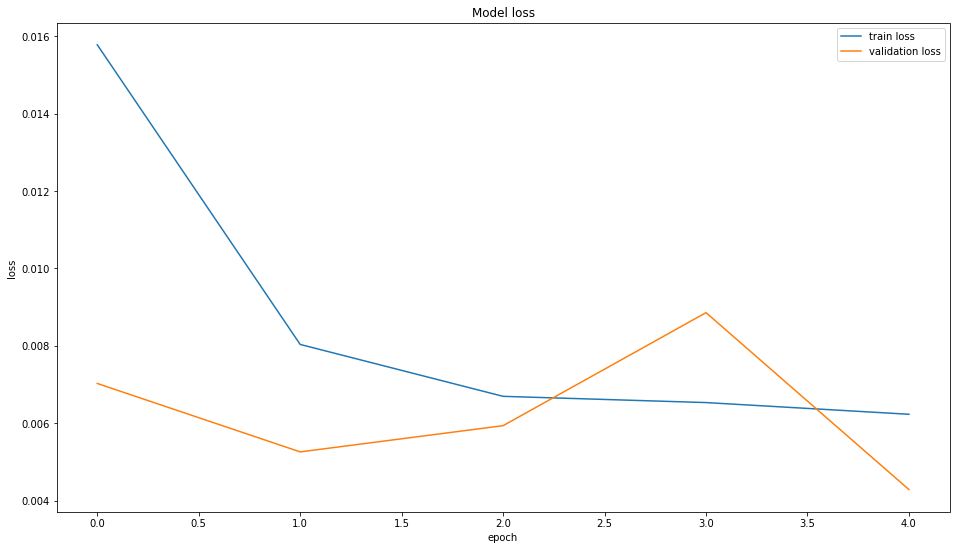

In [58]:
plt.figure(figsize=(16,9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'])
plt.show()

In [59]:
data_val = X_scaler.fit_transform(data[["Zasedenost", "Points_of_interest"]].tail(48))
val_rescaled = data_val.reshape(1, data_val.shape[0], data_val.shape[1])
pred = lstm_model.predict(val_rescaled)
pred_Inverse = Y_scaler.inverse_transform(pred)
pred_Inverse

array([[36.454933, 35.664875, 33.779045, 31.639605, 31.597258, 30.357029,
        27.186531, 30.194208, 29.943502, 28.20623 ]], dtype=float32)

In [60]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}', end='\n\n')

In [61]:
timeseries_evaluation_metrics_func(list(map(lambda el: el[0], data[["Zasedenost"]].tail(10).values)),pred_Inverse[0])

Evaluation metric results:-
MSE is : 297.4682063738452
MAE is : 16.60232162475586
RMSE is : 17.247266634856818
MAPE is : 118.05680226812174
R2 is : -75.46997593157974



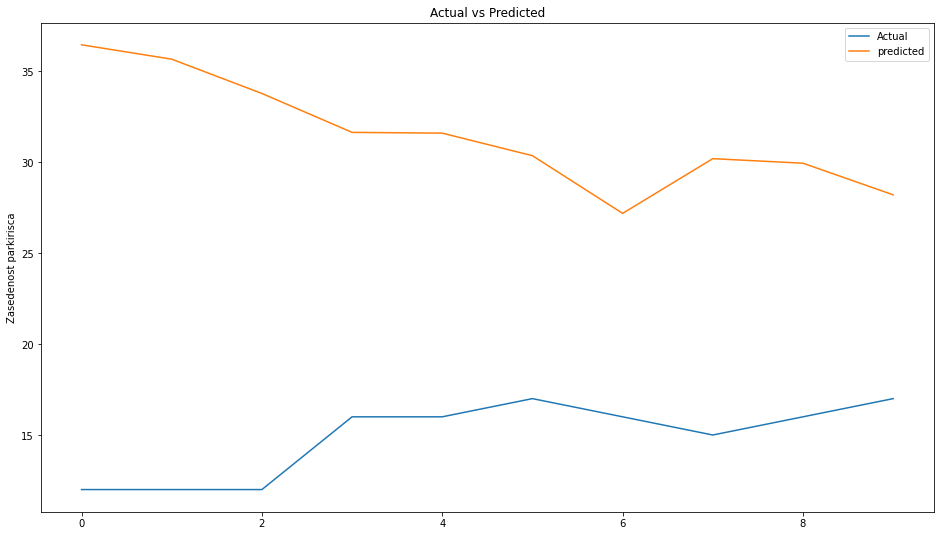

In [62]:
plt.figure(figsize=(16, 9))
plt.plot(list(map(lambda el: el[0], data[["Zasedenost"]].tail(10).values)))
plt.plot(list(pred_Inverse[0]))
plt.title("Actual vs Predicted")
plt.ylabel("Zasedenost parkirisca")
plt.legend(('Actual', 'predicted'))
plt.show()